In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from scipy.sparse import hstack
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
df_clean = pd.read_csv('df_clean.csv')

In [ ]:
df_clean.head()

,Customer Age,Customer Gender,Product Purchased,Ticket Type,Ticket Subject,Ticket Description,Ticket Channel
0,32,Other,GoPro Hero,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Social media
1,42,Female,LG Smart TV,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Chat
2,48,Other,Dell XPS,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Social media
3,27,Female,Microsoft Office,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Social media
4,67,Female,Autodesk AutoCAD,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Email


In [ ]:
df_clean['Ticket Subject'].unique()

array(['Product setup', 'Peripheral compatibility', 'Network problem',
       'Account access', 'Data loss', 'Payment issue', 'Refund request',
       'Battery life', 'Installation support', 'Software bug',
       'Hardware issue', 'Product recommendation', 'Delivery problem',
       'Display issue', 'Cancellation request', 'Product compatibility'],
      dtype=object)

Separate features and target

In [ ]:
X = df_clean[['Customer Age', 'Customer Gender', 'Product Purchased',
              'Ticket Subject', 'Ticket Description', 'Ticket Channel']].copy()
y = df_clean['Ticket Type']

Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
print(f"\n✅ Split: {len(X_train)} train, {len(X_test)} test")


✅ Split: 6775 train, 1694 test


Text Preprocessing

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Custom stopwords (trimmed – removed domain keywords like refund, billing, cancel, etc.)
custom_stopwords = set([
    'issue','im','ive','please','assist','help','support','thanks','thank','dear','customer',
    'team','hi','hello','noticed','thing','make','making','seems','seem','tried'
])

# --- Fill product placeholders ---
def fill_placeholders(row):
    text = str(row['Ticket Description'])
    if 'Product Purchased' in row.index:
        text = text.replace('{product_purchased}', str(row['Product Purchased']))
    return text

# --- Softer cleaning function ---
def balanced_clean(text):
    text = str(text).lower()

    # Remove repetitive formal phrases
    patterns = [
        r"i['’]?\s*m\s*(having|facing|experiencing)\s*(an\s*)?(issue|problem)\s*with",
        r"please\s*(assist|help|resolve)",
        r"can\s*you\s*help\s*me",
        r"let\s*me\s*know",
        r"thank\s*you",
        r"thanks"
    ]
    for pattern in patterns:
        text = re.sub(pattern, '', text)

    # Keep numbers but generalize them
    text = re.sub(r'\$', 'money', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize and clean
    words = text.split()
    cleaned_words = [
        lemmatizer.lemmatize(w)
        for w in words
        if w not in stop_words
        and w not in custom_stopwords
        and len(w) > 2
    ]

    return ' '.join(cleaned_words)

# Apply on train/test
X_train['desc_clean'] = X_train.apply(fill_placeholders, axis=1)
X_test['desc_clean'] = X_test.apply(fill_placeholders, axis=1)

X_train['desc_clean'] = X_train['desc_clean'].apply(balanced_clean)
X_test['desc_clean'] = X_test['desc_clean'].apply(balanced_clean)

print("✅ Balanced text cleaning complete!")

✅ Balanced text cleaning complete!


In [ ]:
X_train

,Customer Age,Customer Gender,Product Purchased,Ticket Subject,Ticket Description,Ticket Channel,desc_clean
4587,32,Other,Canon EOS,Peripheral compatibility,I'm having an issue with the {product_purchase...,Email,canon eos canon eos productpurch occurs consis...
2794,26,Other,Dell XPS,Peripheral compatibility,My {product_purchased} is making strange noise...,Chat,dell xps strange noise functioning properly su...
1679,18,Other,Microsoft Surface,Battery life,I'm having an issue with the {product_purchase...,Social media,microsoft surface name registering product pro...
6863,62,Female,Fitbit Charge,Hardware issue,I've noticed a software bug in the {product_pu...,Chat,software bug fitbit charge app causing data lo...
6395,59,Female,iPhone,Account access,I'm having an issue with the {product_purchase...,Social media,iphone item ship within business day purchase ...
...,...,...,...,...,...,...,...
6111,44,Other,Nest Thermostat,Installation support,I've noticed a software bug in the {product_pu...,Social media,software bug nest thermostat app causing data ...
2933,44,Other,Samsung Soundbar,Account access,I'm having an issue with the {product_purchase...,Email,samsung soundbar note one always donate receiv...
8087,48,Other,LG Smart TV,Refund request,I'm having an issue with the {product_purchase...,Phone,smart one like address first find product stor...
7958,34,Other,PlayStation,Cancellation request,I'm having an issue with the {product_purchase...,Phone,playstation 362 new new getting better better ...


In [ ]:
print("\n" + "="*70)
print("WORD DIVERSITY CHECK (AFTER AGGRESSIVE CLEANING)")
print("="*70)

for ticket_type in y_train.unique():
    texts = X_train[y_train == ticket_type]['desc_clean']
    all_text = ' '.join(texts.values)
    words = all_text.split()
    word_counts = Counter(words)
    top_10 = word_counts.most_common(10)

    print(f"\n{ticket_type}:")
    print(f"  Unique words: {len(word_counts)}")
    print(f"  Top 10: {[word for word, _ in top_10]}")


WORD DIVERSITY CHECK (AFTER AGGRESSIVE CLEANING)

Cancellation request:
  Unique words: 2496
  Top 10: ['problem', 'product', 'update', 'device', 'data', 'step', 'software', 'account', 'work', 'time']

Refund request:
  Unique words: 2468
  Top 10: ['product', 'problem', 'update', 'data', 'device', 'software', 'account', 'step', 'persists', 'sony']

Technical issue:
  Unique words: 2426
  Top 10: ['problem', 'product', 'update', 'device', 'step', 'account', 'software', 'data', 'resolve', 'time']

Product inquiry:
  Unique words: 2488
  Top 10: ['product', 'problem', 'update', 'data', 'software', 'device', 'account', 'step', 'persists', 'time']

Billing inquiry:
  Unique words: 2406
  Top 10: ['product', 'problem', 'update', 'data', 'account', 'software', 'device', 'step', 'work', 'time']


In [ ]:
# Remove these columns
features_to_drop = [
    'Product Purchased',            # Include in desc_clean
    'Ticket Description'            # Include in desc_clean

]

# Clean dataset for modeling
X_train = X_train.drop(columns=features_to_drop)

In [ ]:
X_train

,Customer Age,Customer Gender,Ticket Subject,Ticket Channel,desc_clean
4587,32,Other,Peripheral compatibility,Email,canon eos canon eos productpurch occurs consis...
2794,26,Other,Peripheral compatibility,Chat,dell xps strange noise functioning properly su...
1679,18,Other,Battery life,Social media,microsoft surface name registering product pro...
6863,62,Female,Hardware issue,Chat,software bug fitbit charge app causing data lo...
6395,59,Female,Account access,Social media,iphone item ship within business day purchase ...
...,...,...,...,...,...
6111,44,Other,Installation support,Social media,software bug nest thermostat app causing data ...
2933,44,Other,Account access,Email,samsung soundbar note one always donate receiv...
8087,48,Other,Refund request,Phone,smart one like address first find product stor...
7958,34,Other,Cancellation request,Phone,playstation 362 new new getting better better ...


Feature Engineering

In [ ]:
# Text Features (TF-IDF)
print("\n📝 Creating TF-IDF features...")

tfidf = TfidfVectorizer(
    max_features=300,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.8,
    sublinear_tf=True
)

X_train_text = tfidf.fit_transform(X_train['desc_clean'])
X_test_text = tfidf.transform(X_test['desc_clean'])

print(f"   Text features: {X_train_text.shape}")


📝 Creating TF-IDF features...
   Text features: (6775, 300)


In [ ]:
# Structured Features

print("\n🏗️  Encoding structured features...")

structured_cols = ['Customer Gender','Ticket Subject', 'Ticket Channel']
numerical_cols = ['Customer Age']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), structured_cols),
        ('num', StandardScaler(), numerical_cols)   # ✅ Standardize Age column
    ]
)


🏗️  Encoding structured features...


In [ ]:
X_train_struct = preprocessor.fit_transform(X_train[structured_cols + numerical_cols])
X_test_struct = preprocessor.transform(X_test[structured_cols + numerical_cols])

print(f"   Structured features: {X_train_struct.shape}")

   Structured features: (6775, 24)


In [ ]:
# Combine All Features

print("\n🔗 Combining features...")

X_train_combined = hstack([X_train_text, X_train_struct])
X_test_combined = hstack([X_test_text, X_test_struct])

print(f"   Combined features: {X_train_combined.shape}")


🔗 Combining features...
   Combined features: (6775, 324)


In [ ]:
print("\n" + "="*70)
print("TRAINING MODELS")
print("="*70)

models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        C=1.0,
        random_state=42,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
}

results = {}
predictions = {}

for name, model in models.items():
    print(f"\n🚀 Training {name}...")

    model.fit(X_train_struct, y_train)
    y_pred = model.predict(X_test_struct)

    predictions[name] = y_pred
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"   ✅ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Check prediction diversity
    unique_preds = len(np.unique(y_pred))
    print(f"   Predicting {unique_preds}/5 classes")


TRAINING MODELS

🚀 Training Logistic Regression...
   ✅ Accuracy: 0.1800 (18.00%)
   Predicting 5/5 classes

🚀 Training Random Forest...
   ✅ Accuracy: 0.1877 (18.77%)
   Predicting 5/5 classes

🚀 Training Gradient Boosting...
   ✅ Accuracy: 0.1889 (18.89%)
   Predicting 5/5 classes


In [ ]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
y_pred_best = predictions[best_model_name]

print("\n" + "="*70)
print(f"✅ BEST MODEL: {best_model_name}")
print("="*70)

print(f"\nAccuracy: {results[best_model_name]:.4f} ({results[best_model_name]*100:.2f}%)")

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_pred_best, zero_division=0))


✅ BEST MODEL: Gradient Boosting

Accuracy: 0.1889 (18.89%)

CLASSIFICATION REPORT
                      precision    recall  f1-score   support

     Billing inquiry       0.21      0.18      0.19       327
Cancellation request       0.19      0.21      0.20       339
     Product inquiry       0.18      0.17      0.17       328
      Refund request       0.18      0.19      0.19       351
     Technical issue       0.19      0.20      0.19       349

            accuracy                           0.19      1694
           macro avg       0.19      0.19      0.19      1694
        weighted avg       0.19      0.19      0.19      1694



In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred_best)
class_names = sorted(y.unique())

print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print(cm_df)


Confusion Matrix:
                      Billing inquiry  Cancellation request  Product inquiry  \
Billing inquiry                    59                    77               58   
Cancellation request               51                    70               58   
Product inquiry                    56                    66               56   
Refund request                     57                    89               76   
Technical issue                    57                    67               64   

                      Refund request  Technical issue  
Billing inquiry                   63               70  
Cancellation request              63               97  
Product inquiry                   78               72  
Refund request                    66               63  
Technical issue                   92               69  


[None, None, None, None, None, None, None, None, None, None]

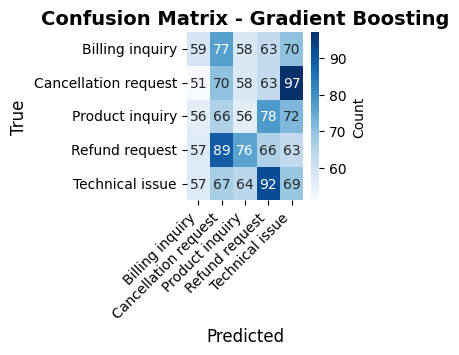

In [ ]:
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
ax2.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('True', fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax2.get_yticklabels(), rotation=0, fontsize=10)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Initialize model
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train_combined, y_train)

# Predict on test set
y_pred = nb_model.predict(X_test_combined)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


ValueError: Negative values in data passed to MultinomialNB (input X).

In [ ]:
print("\n" + "="*70)
print("TRAINING MODELS")
print("="*70)

models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        C=1.0,
        random_state=42,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
}

results = {}
predictions = {}

for name, model in models.items():
    print(f"\n🚀 Training {name}...")

    model.fit(X_train_combined, y_train)
    y_pred = model.predict(X_test_combined)

    predictions[name] = y_pred
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"   ✅ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Check prediction diversity
    unique_preds = len(np.unique(y_pred))
    print(f"   Predicting {unique_preds}/5 classes")


TRAINING MODELS

🚀 Training Logistic Regression...
   ✅ Accuracy: 0.1877 (18.77%)
   Predicting 5/5 classes

🚀 Training Random Forest...
   ✅ Accuracy: 0.2090 (20.90%)
   Predicting 5/5 classes

🚀 Training Gradient Boosting...
   ✅ Accuracy: 0.2102 (21.02%)
   Predicting 5/5 classes


In [ ]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
y_pred_best = predictions[best_model_name]

print("\n" + "="*70)
print(f"✅ BEST MODEL: {best_model_name}")
print("="*70)

print(f"\nAccuracy: {results[best_model_name]:.4f} ({results[best_model_name]*100:.2f}%)")

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_pred_best, zero_division=0))


✅ BEST MODEL: Gradient Boosting

Accuracy: 0.2102 (21.02%)

CLASSIFICATION REPORT
                      precision    recall  f1-score   support

     Billing inquiry       0.22      0.18      0.20       327
Cancellation request       0.18      0.18      0.18       339
     Product inquiry       0.18      0.15      0.16       328
      Refund request       0.24      0.33      0.28       351
     Technical issue       0.21      0.21      0.21       349

            accuracy                           0.21      1694
           macro avg       0.21      0.21      0.21      1694
        weighted avg       0.21      0.21      0.21      1694



[None, None, None, None, None, None, None, None, None, None]

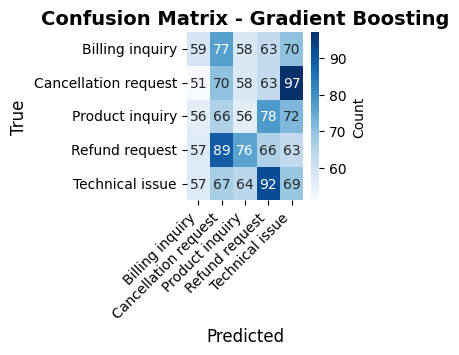

In [ ]:
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
ax2.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('True', fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax2.get_yticklabels(), rotation=0, fontsize=10)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
max_words = 10000  # Vocabulary size
max_len = 100      # Max sequence length

# Combine subject + description for training
train_text = X_train['Ticket Subject'] + " " + X_train['desc_clean']
test_text = X_test['Ticket Subject'] + " " + X_test['desc_clean']

# Tokenize
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_text)

X_train_seq = tokenizer.texts_to_sequences(train_text)
X_test_seq = tokenizer.texts_to_sequences(test_text)

# Pad sequences
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Convert to categorical for multi-class classification
y_train_enc = tf.keras.utils.to_categorical(y_train_enc)
y_test_enc = tf.keras.utils.to_categorical(y_test_enc)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train_enc.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_seq,
    y_train_enc,
    validation_split=0.1,
    epochs=20,
    batch_size=64
)


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.1971 - loss: 1.6127 - val_accuracy: 0.1799 - val_loss: 1.6107
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2053 - loss: 1.6098 - val_accuracy: 0.2080 - val_loss: 1.6108
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2038 - loss: 1.6104 - val_accuracy: 0.1799 - val_loss: 1.6127
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1951 - loss: 1.6100 - val_accuracy: 0.1799 - val_loss: 1.6120
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2027 - loss: 1.6099 - val_accuracy: 0.1799 - val_loss: 1.6103
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2007 - loss: 1.6100 - val_accuracy: 0.2080 - val_loss: 1.6098
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2104 - loss: 1.6093 - val_accuracy: 0.2080 - val_loss: 1.6111
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2057 - loss: 1.6100 - val_accuracy: 0.1799 - v

In [ ]:
loss, accuracy = model.evaluate(X_test_seq, y_test_enc)
print(f"Test Accuracy: {accuracy:.4f}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1997 - loss: 1.6100
Test Accuracy: 0.2060


In [ ]:
# ============================================================================
# BERT Fine-tuning for Customer Support Ticket Classification
# ============================================================================

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("BERT TICKET CLASSIFICATION - SETUP")
print("=" * 80)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")
if device.type == 'cuda':
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# ============================================================================
# 1. LOAD AND PREPARE DATA
# ============================================================================

print("\n" + "=" * 80)
print("1. DATA PREPARATION")
print("=" * 80)

# Load your cleaned dataset
df_clean = pd.read_csv('df_clean.csv')
print(f"\n✓ Loaded dataset: {df_clean.shape[0]} tickets")

# Combine Subject + Description for better context
df_clean['text'] = (
    df_clean['Ticket Subject'].fillna('') + ' [SEP] ' +
    df_clean['Ticket Description'].fillna('')
)

# Prepare features and target
X = df_clean['text']
y = df_clean['Ticket Type']

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"✓ Classes: {list(label_encoder.classes_)}")
print(f"✓ Number of classes: {len(label_encoder.classes_)}")

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"\n✓ Train set: {len(X_train)} tickets")
print(f"✓ Test set: {len(X_test)} tickets")

# ============================================================================
# 2. TOKENIZATION
# ============================================================================

print("\n" + "=" * 80)
print("2. BERT TOKENIZATION")
print("=" * 80)

# Initialize BERT tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

print(f"\n✓ Loaded tokenizer: {model_name}")

# Tokenization parameters
MAX_LEN = 128  # Maximum sequence length (adjust based on ticket length)

def tokenize_data(texts, labels, tokenizer, max_len):
    """Tokenize text data for BERT"""
    input_ids = []
    attention_masks = []

    for text in tqdm(texts, desc="Tokenizing"):
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,      # Add [CLS] and [SEP]
            max_length=max_len,
            padding='max_length',          # Pad to max_length
            truncation=True,               # Truncate if longer
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Convert to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

# Tokenize train and test sets
print("\nTokenizing training data...")
train_inputs, train_masks, train_labels = tokenize_data(
    X_train.values, y_train, tokenizer, MAX_LEN
)

print("Tokenizing test data...")
test_inputs, test_masks, test_labels = tokenize_data(
    X_test.values, y_test, tokenizer, MAX_LEN
)

print(f"\n✓ Tokenization complete!")
print(f"  Train input shape: {train_inputs.shape}")
print(f"  Test input shape: {test_inputs.shape}")

# ============================================================================
# 3. CREATE PYTORCH DATASET AND DATALOADER
# ============================================================================

print("\n" + "=" * 80)
print("3. CREATING PYTORCH DATALOADERS")
print("=" * 80)

class TicketDataset(Dataset):
    """Custom Dataset for ticket classification"""

    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

# Create datasets
train_dataset = TicketDataset(train_inputs, train_masks, train_labels)
test_dataset = TicketDataset(test_inputs, test_masks, test_labels)

# Create dataloaders
BATCH_SIZE = 16  # Adjust based on GPU memory

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Set to 0 for Windows compatibility
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"\n✓ DataLoaders created")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Train batches: {len(train_dataloader)}")
print(f"  Test batches: {len(test_dataloader)}")

# ============================================================================
# 4. INITIALIZE BERT MODEL
# ============================================================================

print("\n" + "=" * 80)
print("4. INITIALIZING BERT MODEL")
print("=" * 80)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    output_attentions=False,
    output_hidden_states=False
)

# Move model to GPU if available
model.to(device)

print(f"\n✓ Model loaded: {model_name}")
print(f"✓ Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"✓ Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ============================================================================
# 5. TRAINING CONFIGURATION
# ============================================================================

print("\n" + "=" * 80)
print("5. TRAINING CONFIGURATION")
print("=" * 80)

# Training hyperparameters
EPOCHS = 4  # BERT typically needs 2-4 epochs
LEARNING_RATE = 2e-5  # Recommended for BERT fine-tuning
WARMUP_STEPS = 0
EPSILON = 1e-8

# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    eps=EPSILON
)

# Learning rate scheduler
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f"\n✓ Optimizer: AdamW")
print(f"✓ Learning rate: {LEARNING_RATE}")
print(f"✓ Epochs: {EPOCHS}")
print(f"✓ Total training steps: {total_steps}")

# ============================================================================
# 6. TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []

    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Clear gradients
        model.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()
        scheduler.step()

        # Track metrics
        total_loss += loss.item()
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)

    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    """Evaluate model on validation/test set"""
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            # Track metrics
            total_loss += loss.item()
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)

    return avg_loss, accuracy, predictions, true_labels

# ============================================================================
# 7. TRAINING LOOP
# ============================================================================

print("\n" + "=" * 80)
print("6. TRAINING BERT MODEL")
print("=" * 80)

training_stats = []
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print('='*80)

    # Train
    train_loss, train_acc = train_epoch(
        model, train_dataloader, optimizer, scheduler, device
    )

    # Evaluate on test set
    test_loss, test_acc, _, _ = evaluate(model, test_dataloader, device)

    # Store statistics
    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'test_loss': test_loss,
        'test_acc': test_acc
    })

    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"  Test Loss:  {test_loss:.4f} | Test Accuracy:  {test_acc:.4f}")
    print('='*80)

    # Save best model
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        torch.save(model.state_dict(), 'best_bert_model.pt')
        print(f"\n✓ Best model saved! (Accuracy: {best_accuracy:.4f})")

# ============================================================================
# 8. FINAL EVALUATION
# ============================================================================

print("\n" + "=" * 80)
print("7. FINAL EVALUATION ON TEST SET")
print("=" * 80)

# Load best model
model.load_state_dict(torch.load('best_bert_model.pt'))

# Final evaluation
test_loss, test_acc, predictions, true_labels = evaluate(
    model, test_dataloader, device
)

print(f"\n{'='*80}")
print(f"FINAL TEST RESULTS")
print(f"{'='*80}")
print(f"\nTest Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# ============================================================================
# 9. CLASSIFICATION REPORT
# ============================================================================

print("\n" + "=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)

# Convert predictions back to class names
predicted_labels = label_encoder.inverse_transform(predictions)
actual_labels = label_encoder.inverse_transform(true_labels)

# Classification report
print("\n" + classification_report(
    actual_labels,
    predicted_labels,
    target_names=label_encoder.classes_,
    digits=4
))

# ============================================================================
# 10. CONFUSION MATRIX
# ============================================================================

print("\n" + "=" * 80)
print("CONFUSION MATRIX")
print("=" * 80)

cm = confusion_matrix(actual_labels, predicted_labels, labels=label_encoder.classes_)
cm_df = pd.DataFrame(
    cm,
    index=label_encoder.classes_,
    columns=label_encoder.classes_
)

print("\n", cm_df)

# ============================================================================
# 11. TRAINING HISTORY
# ============================================================================

print("\n" + "=" * 80)
print("TRAINING HISTORY")
print("=" * 80)

history_df = pd.DataFrame(training_stats)
print("\n", history_df.to_string(index=False))

# ============================================================================
# 12. COMPARISON WITH BASELINE
# ============================================================================

print("\n" + "=" * 80)
print("PERFORMANCE IMPROVEMENT")
print("=" * 80)

baseline_accuracy = 0.2102  # Gradient Boosting accuracy
improvement = (test_acc - baseline_accuracy) * 100

print(f"\nBaseline (Gradient Boosting): {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"BERT Fine-tuned:              {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"\n{'='*80}")
if improvement > 0:
    print(f"✓ IMPROVEMENT: +{improvement:.2f} percentage points!")
else:
    print(f"⚠ Performance change: {improvement:.2f} percentage points")
print(f"{'='*80}")

# ============================================================================
# 13. SAVE RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("SAVING RESULTS")
print("=" * 80)

# Save predictions
results_df = pd.DataFrame({
    'actual': actual_labels,
    'predicted': predicted_labels,
    'correct': actual_labels == predicted_labels
})
results_df.to_csv('bert_predictions.csv', index=False)
print("\n✓ Predictions saved to 'bert_predictions.csv'")

# Save training history
history_df.to_csv('bert_training_history.csv', index=False)
print("✓ Training history saved to 'bert_training_history.csv'")

# Save label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✓ Label encoder saved to 'label_encoder.pkl'")

print("\n" + "=" * 80)
print("TRAINING COMPLETE!")
print("=" * 80)
print(f"\n✓ Best model saved as 'best_bert_model.pt'")
print(f"✓ Final test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"✓ All results saved successfully!")
print("\n" + "=" * 80)

BERT TICKET CLASSIFICATION - SETUP

✓ Using device: cpu

1. DATA PREPARATION

✓ Loaded dataset: 8469 tickets
✓ Classes: ['Billing inquiry', 'Cancellation request', 'Product inquiry', 'Refund request', 'Technical issue']
✓ Number of classes: 5

✓ Train set: 6775 tickets
✓ Test set: 1694 tickets

2. BERT TOKENIZATION


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


✓ Loaded tokenizer: bert-base-uncased

Tokenizing training data...


Tokenizing: 100%|██████████| 6775/6775 [00:10<00:00, 619.92it/s]


Tokenizing test data...


Tokenizing: 100%|██████████| 1694/1694 [00:02<00:00, 588.88it/s]



✓ Tokenization complete!
  Train input shape: torch.Size([6775, 128])
  Test input shape: torch.Size([1694, 128])

3. CREATING PYTORCH DATALOADERS

✓ DataLoaders created
  Batch size: 16
  Train batches: 424
  Test batches: 106

4. INITIALIZING BERT MODEL


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Model loaded: bert-base-uncased
✓ Number of parameters: 109,486,085
✓ Trainable parameters: 109,486,085

5. TRAINING CONFIGURATION

✓ Optimizer: AdamW
✓ Learning rate: 2e-05
✓ Epochs: 4
✓ Total training steps: 1696

6. TRAINING BERT MODEL

Epoch 1/4


Training:  38%|███▊      | 163/424 [59:29<1:34:00, 21.61s/it, loss=1.5923]